<a href="https://colab.research.google.com/github/monya-9/deep-learning-practice/blob/main/03_rnn_sinewave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN → 간단한 시계열 예측

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
# 1. 시계열 데이터 생성 (sin wave)
np.random.seed(0)
timesteps = np.linspace(0, 100, 1000)
data = np.sin(timesteps) + 0.1 * np.random.randn(1000)  # 잡음 추가

1. 사인파에 잡음을 추가하여 예측 난이도를 높임
2. 총 1000개의 데이터 포인터 생성

In [3]:
# 2. 시퀀스 데이터셋 만들기
def create_dataset(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
X, y = create_dataset(data, seq_length)

X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1) # (배치, seq, feature)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


1. 입력 seq_length 길이 만큼 과거 데이터를 보고, 다음 시점을 예측
2. 시계열을 학습용 입력과 레이블로 변환

In [4]:

# 3. LSTM 모델
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # 마지막 시점 출력
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

1. LSTM: 시계열 데이터의 장기 의존성 학습 가능
2. 마지막 시점(hidden state)을 FC층에 전달하여 다음 값을 예측
3. 손실 함수: MSE (연속 값 예측에 적합)
4. 옵티마이저: Adam (확률 자동 조정)

In [5]:
# 4. 학습
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/50], Loss: {loss.item():.4f}")

Epoch [10/50], Loss: 0.0507
Epoch [20/50], Loss: 0.0206
Epoch [30/50], Loss: 0.0176
Epoch [40/50], Loss: 0.0181
Epoch [50/50], Loss: 0.0162


1. 매 epoch마다 전체 학습 데이터를 사용하여 가중치 업데이트
2. loss.backward() -> 역전파
3. optimizer.step() -> 가중치 갱신

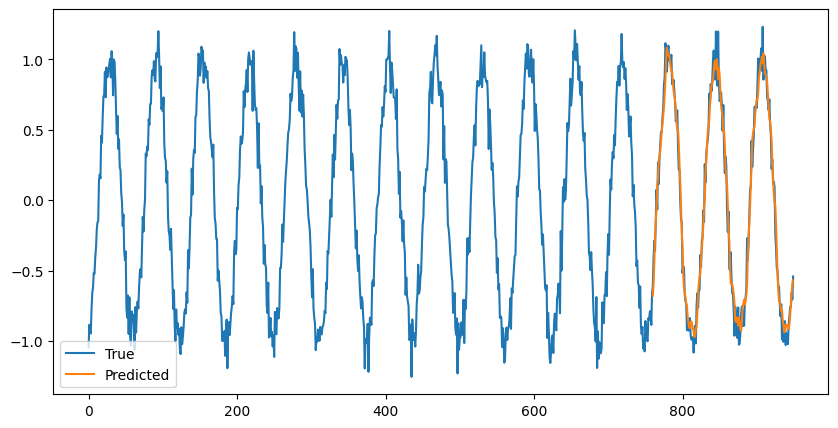

In [6]:
# 5. 예측
model.eval()
predicted = model(X_test.to(device)).detach().cpu().numpy()

plt.figure(figsize=(10,5))
plt.plot(range(len(y)), y, label='True')
plt.plot(range(train_size, len(y)), predicted, label='Predicted')
plt.legend()
plt.show()

1. 테스트 데이터로 예측 수행
2. detach().cpu().numpy() -> PyTorch tensor -> Numpy array 변환
3. 시각화를 통해 모델이 실제 시계열을 어마나 잘 따라가는지 확인